In [1]:
import torch
import torchvision

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from EvolvedNNPopulation import NSGSIIPopulation
from EvolvedNN import EvolvedNN

from BatchLayers.StatLayers import Mean, Variance

from CombineLayers.ElementWiseLayers import Add, Multiply

from CompoundLayers.SequentialLayer import Sequential
from CompoundLayers.SplitLayer import Split

from MutableLayers.MutableSplitLayers import MutableAddSplit, MutableMulSplit, MutableMaxSplit, MutablePowSplit
from MutableLayers.MutableResizeLayers import MutableResizeFive, MutableResizeFifth

from OpLayers.AffineLayers import Linear, AddBias, LinearResize
from OpLayers.ScalarFuncLayers import Log, Exp, Identity, Abs, Sin, Reciprocal
from OpLayers.VectorFuncLayers import Pow, Scale

In [2]:
op_layers = [ Linear, AddBias, Exp, Sin, Pow ]
split_layers = [ MutableAddSplit, MutableMulSplit, MutableMaxSplit, MutablePowSplit ]
batch_layers = [ Mean, Variance ]
resize_layers = [ MutableResizeFive, MutableResizeFifth]

layers = split_layers + op_layers + resize_layers

In [68]:
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dim = 28 ** 2

batch_size= 32

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), lambda t : t.to(device), torchvision.transforms.Normalize((0.5,), (0.5,)), torch.flatten])

train_set = torchvision.datasets.MNIST(root='./data/', train=True, download=True, transform=transform)
train_set_small = torch.utils.data.Subset(train_set, np.random.choice(len(train_set), 1000, replace=False))

test_set = torchvision.datasets.MNIST(root='./data/', train=False, download=True, transform=transform)
test_set_small = torch.utils.data.Subset(test_set, np.random.choice(len(test_set), 500, replace=False))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
train_loader_small = torch.utils.data.DataLoader(train_set_small, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)
test_loader_small = torch.utils.data.DataLoader(test_set_small, batch_size=batch_size, shuffle=True)

In [90]:
n = 50

population = NSGSIIPopulation(dim, 10, n, device=device)

population.initialize_randomly(layers, 5, loss_fn=torch.nn.CrossEntropyLoss())
population.gen_children(3, layers, weights=True, p=[0.4, 0.2, 0.4])

population.train_pool_dataloader(train_loader_small, 10)
population.evaluate_pool_dataloader(test_loader_small)

for step in range(100):
    print(f"Step {step}")

    print(f"Best stats: {population.stats[:8]}")

    population.train_children_dataloader(train_loader_small, 10)
    population.evaluate_children_dataloader(test_loader_small)

    population.step(percentile=0.9)
    population.gen_children(3, layers, weights=True, p=[0.4, 0.2, 0.4])

Training Pool:   2%|▏         | 1/50 [00:06<04:59,  6.11s/it]


KeyboardInterrupt: 

In [101]:
total_correct = 0

best_model = population.pool[0]

for i in range(len(test_set)):
    img, label = test_set[i]
    img_disp = img.reshape(28, 28)

    # plt.imshow(img_disp)
    # plt.show()

    best_model(img.to(device))

    # print(f"Predicted: {best_model(img.to(device)).argmax()}")
    # print(f"Actual: {label}")

    total_correct += best_model(img.to(device)).argmax() == label

KeyboardInterrupt: 

In [100]:
print(best_model(test_set[80][0].to(device)))
print(test_set[100][1])

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       grad_fn=<SqueezeBackward4>)
6


In [95]:
print(total_correct)
print(len(test_set))

tensor(980, device='cuda:0')
10000


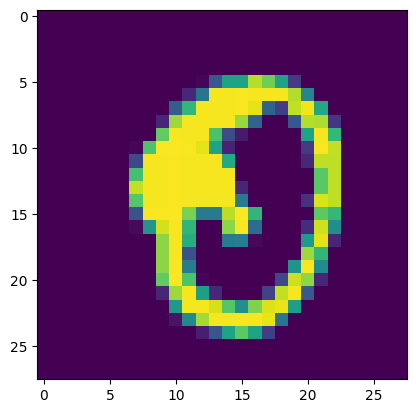

Predicted logit: tensor([ 0.7150, -4.3069, -4.0084, -0.1935, -0.3231,  2.6780,  0.2071, -4.2338,
         3.2017,  0.2438], grad_fn=<SqueezeBackward4>), label: 8 
Actual: 0


In [62]:
i = 462

img, label = test_set_small[i]
img_disp = img.reshape(28, 28)

plt.imshow(img_disp)
plt.show()

pred = best_model(img)

print(f"Predicted logit: {best_model(img)}, label: {pred.argmax()} ")
print(f"Actual: {label}")

In [45]:
new_model = best_model.copy(True)
print(new_model.cpu())

EvolvedNN(
  dim=784
  (first): LinearResize(
    in_dim=784, out_dim=784, A=[[-0.57313037  0.6569726  -0.34968802 ...  0.5008872   0.48217225
      -0.71117264]
     [ 0.7285583   0.5051801  -1.1661336  ...  0.10000397  0.03608151
       0.19621277]
     [ 0.78597945  1.3475919   0.11014132 ...  0.0515542   1.0678568
       0.15678416]
     ...
     [ 0.41570485  0.94372034  0.08462043 ... -0.61864215 -0.3722375
       0.9435736 ]
     [-0.3651984   0.28290504 -0.10693131 ...  0.74309057  0.9134775
       0.6858764 ]
     [ 0.36464268  0.55265814 -0.27351755 ... -0.38459188  0.08669129
       0.58644164]]
  )
  (latent): MutableSequential(
    dim=784
    (layers): ModuleList(
      (0): Pow(
        dim=784, exp=[-0.6609943   0.98380816  1.0612868   0.97421426  0.31516805  0.08070858
          1.0649961   0.4472298  -0.4100657   0.42345643  1.407736    1.0599953
         -0.6693107  -0.47666454 -0.6083352   0.7993922  -0.673752    0.5827444
          0.7321645  -0.89668703 -1.0294513

In [56]:
new_pool = population.pool
print(new_pool.cpu())

ModuleList(
  (0): EvolvedNN(
    dim=784
    (first): LinearResize(
      in_dim=784, out_dim=784, A=[[-0.57313037  0.6569726  -0.34968802 ...  0.5008872   0.48217225
        -0.71117264]
       [ 0.7285583   0.5051801  -1.1661336  ...  0.10000397  0.03608151
         0.19621277]
       [ 0.78597945  1.3475919   0.11014132 ...  0.0515542   1.0678568
         0.15678416]
       ...
       [ 0.41570485  0.94372034  0.08462043 ... -0.61864215 -0.3722375
         0.9435736 ]
       [-0.3651984   0.28290504 -0.10693131 ...  0.74309057  0.9134775
         0.6858764 ]
       [ 0.36464268  0.55265814 -0.27351755 ... -0.38459188  0.08669129
         0.58644164]]
    )
    (latent): MutableSequential(
      dim=784
      (layers): ModuleList(
        (0): Pow(
          dim=784, exp=[-0.6609943   0.98380816  1.0612868   0.97421426  0.31516805  0.08070858
            1.0649961   0.4472298  -0.4100657   0.42345643  1.407736    1.0599953
           -0.6693107  -0.47666454 -0.6083352   0.7993922  -

In [92]:
model = EvolvedNN(dim, 10, loss_fn=torch.nn.CrossEntropyLoss())
model.to(device)

model.train_dataloader(train_loader_small, 10)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat2 in method wrapper_CUDA_mm)